# Solução de Problemas de Negócio

Este notebook resolve questões específicas de negócio com análises avançadas:

1. Análise de Retenção
2. Predição de Atraso
3. Segmentação de Clientes 
4. Análise de Satisfação

## Configuração Inicial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sqlite3
import warnings
import os
warnings.filterwarnings("ignore")


# Configurações de visualização

In [2]:
plt.rcParams['figure.figsize'] = (11, 7)
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.style.use('ggplot')
%matplotlib inline

# Conexão com a camada Gold

In [3]:
if os.path.exists('../gold/gold_layer.db'):
    db_path = '../gold/gold_layer.db'
    output_path = '../dashboards/'
else:
    db_path = 'gold/gold_layer.db'
    output_path = 'dashboards/'

conn = sqlite3.connect('../gold/gold_layer.db')

## 1. Análise de Retenção

Total de clientes: 95420
Clientes recorrentes: 2913
Taxa de retenção: 3.05%

Insights sobre a Retenção de Clientes:
1. A baixa taxa de retenção indica um desafio significativo para o negócio
2. A maioria dos clientes faz apenas uma compra e não retorna
3. Recomendações: implementar programa de fidelidade e melhorar a experiência pós-compra


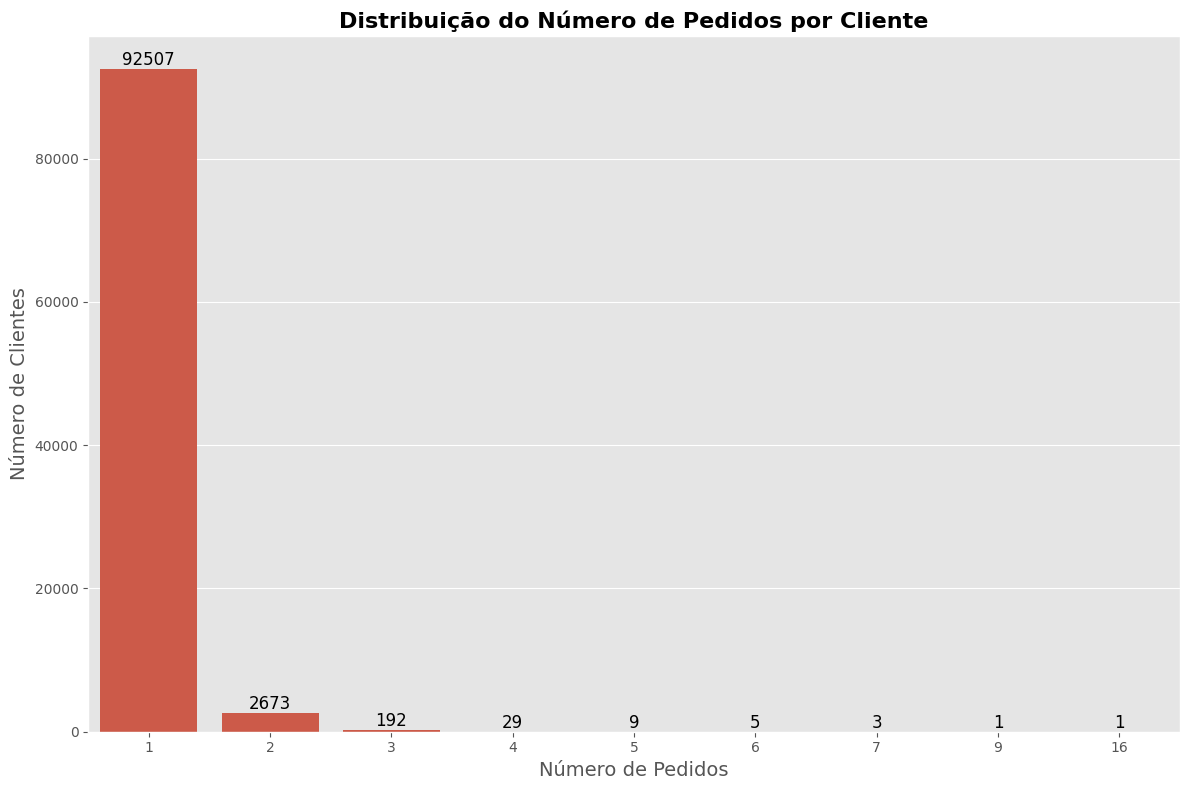

In [4]:
query = """
SELECT c.customer_unique_id, COUNT(DISTINCT fs.order_id) as order_count
FROM DIM_CUSTOMERS c
JOIN FACT_SALES fs ON c.customer_id = fs.customer_id
GROUP BY c.customer_unique_id
"""

retention_data = pd.read_sql_query(query, conn)

def analyze_retention(data):
    total_customers = len(data)
    recurring_customers = len(data[data['order_count'] > 1])
    retention_rate = (recurring_customers / total_customers) * 100
        
    print(f"Total de clientes: {total_customers}")
    print(f"Clientes recorrentes: {recurring_customers}")
    print(f"Taxa de retenção: {retention_rate:.2f}%")
    
    plt.figure(figsize=(12, 8))
    ax = sns.countplot(x='order_count', data=data)
    plt.title('Distribuição do Número de Pedidos por Cliente', fontsize=16, fontweight='bold')
    plt.xlabel('Número de Pedidos', fontsize=14)
    plt.ylabel('Número de Clientes', fontsize=14)
    
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'bottom', 
                    fontsize=12)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'retention_analysis.png'), dpi=300)
    
    return {
        'total_customers': total_customers,
        'recurring_customers': recurring_customers,
        'retention_rate': retention_rate
    }

retention_results = analyze_retention(retention_data)

print("\nInsights sobre a Retenção de Clientes:")
print("1. A baixa taxa de retenção indica um desafio significativo para o negócio")
print("2. A maioria dos clientes faz apenas uma compra e não retorna")
print("3. Recomendações: implementar programa de fidelidade e melhorar a experiência pós-compra")

## 2. Predição de Atraso


In [8]:
query = """
SELECT 
    fs.order_id,
    fs.price,
    fs.freight_value,
    JULIANDAY(fs.order_delivered_customer_date) - JULIANDAY(fs.order_purchase_timestamp) AS delivery_time,
    JULIANDAY(fs.order_estimated_delivery_date) - JULIANDAY(fs.order_purchase_timestamp) AS estimated_delivery_time,
    CASE 
        WHEN JULIANDAY(fs.order_delivered_customer_date) > JULIANDAY(fs.order_estimated_delivery_date) THEN 1
        ELSE 0
    END as is_delayed,
    c.customer_state,
    s.seller_state,
    p.product_weight_g as weight_g,
    p.product_volume_cm3 as volume_cm3,
    p.product_category_name as category_name
FROM FACT_SALES fs
JOIN DIM_CUSTOMERS c ON fs.customer_id = c.customer_id
JOIN DIM_SELLERS s ON fs.seller_id = s.seller_id
JOIN DIM_PRODUCTS p ON fs.product_id = p.product_id
WHERE fs.order_delivered_customer_date IS NOT NULL
"""

delivery_data = pd.read_sql_query(query, conn)

def predict_delay(data):
    data = data.dropna()
    
    data['same_state'] = (data['customer_state'] == data['seller_state']).astype(int)
    data['price_to_freight_ratio'] = data['price'] / (data['freight_value'] + 1)  # Evitar divisão por zero
    
    data = pd.get_dummies(data, columns=['customer_state', 'seller_state'], drop_first=True)
    
    features = [col for col in data.columns if col not in ['order_id', 'is_delayed', 'category_name']]
    X = data[features]
    y = data['is_delayed']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    
    y_pred = rf_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(x='importance', y='feature', data=feature_importance.head(15), palette='viridis')
    plt.title('Top 15 Features que Influenciam no Atraso de Entrega', fontsize=16, fontweight='bold')
    plt.xlabel('Importância Relativa', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    
    for i, v in enumerate(feature_importance.head(15)['importance']):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=12)
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'delay_prediction_features.png'), dpi=300)
    
    plt.figure(figsize=(10, 8))
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Não Atrasado', 'Atrasado'], 
                yticklabels=['Não Atrasado', 'Atrasado'])

    plt.title('Matriz de Confusão - Predição de Atraso', fontsize=16, fontweight='bold')
    plt.xlabel('Predição', fontsize=14)
    plt.ylabel('Valor Real', fontsize=14)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=['Não Atrasado', 'Atrasado'], 
                yticklabels=['Não Atrasado', 'Atrasado'])

    plt.title('Matriz de Confusão (%) - Predição de Atraso', fontsize=16, fontweight='bold')
    plt.xlabel('Predição', fontsize=14)
    plt.ylabel('Valor Real', fontsize=14)

    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'delay_prediction_confusion.png'), dpi=300)

    class_report = classification_report(y_test, y_pred, output_dict=True)
    metrics = pd.DataFrame({
        'Métrica': ['Acurácia', 'Precisão (Atraso)', 'Recall (Atraso)', 'F1-Score (Atraso)'],
        'Valor': [accuracy, 
                class_report['1']['precision'], 
                class_report['1']['recall'], 
                class_report['1']['f1-score']]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Métrica', y='Valor', data=metrics, palette='viridis')
    plt.title('Métricas de Desempenho do Modelo de Predição de Atraso', fontsize=16, fontweight='bold')
    plt.ylim(0, 1.0)
    plt.ylabel('Valor', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for i, v in enumerate(metrics['Valor']):
        ax.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'delay_prediction_metrics.png'), dpi=300)
    
    print(f"\nAccuracy do modelo: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    
    return {
        'model': rf_model,
        'accuracy': accuracy,
        'feature_importance': feature_importance,
        'X_test': X_test_scaled,
        'y_test': y_test,
        'y_pred': y_pred
    }
    
delay_results = predict_delay(delivery_data)

## 3. Segmentação de Clientes


Perfil dos Segmentos de Clientes:
   cluster            segment_name  total_orders  avg_order_value  total_spent
0        0              Alto Valor      1.017773      1015.552803  1218.992354
1        1  Compradores Frequentes      1.839565       118.070463   306.268996
2        2     Compradores Casuais      1.012446       116.201005   132.872124
3        3       Baixo Engajamento      1.012688       148.713339   168.812297

Estratégias de Marketing por Segmento:
Segmento 0: Alto Valor
Estratégia: Programa de fidelidade premium, ofertas exclusivas e atendimento personalizado

Segmento 1: Compradores Frequentes
Estratégia: Incentivos para aumentar ticket médio, cross-selling e upselling

Segmento 2: Compradores Casuais
Estratégia: Comunicações regulares com ofertas de categorias já compradas

Segmento 3: Baixo Engajamento
Estratégia: Re-engajamento com descontos atrativos e frete grátis



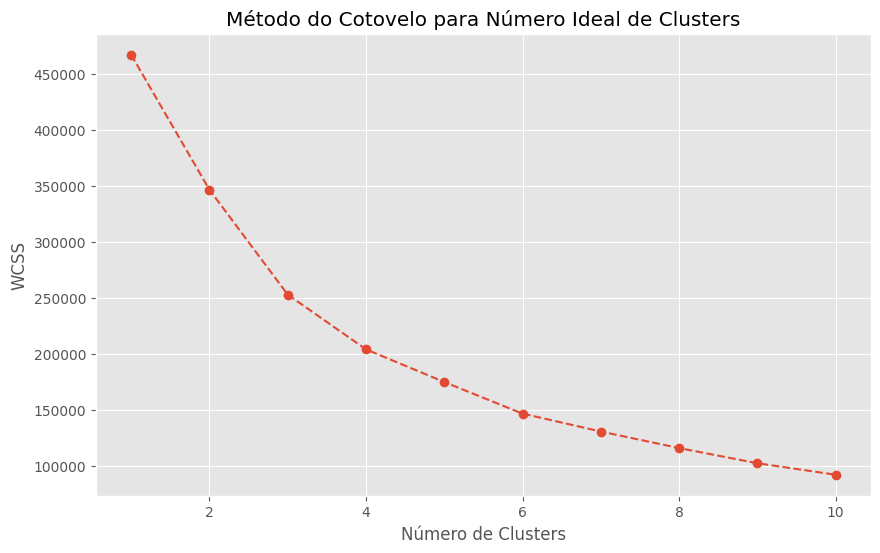

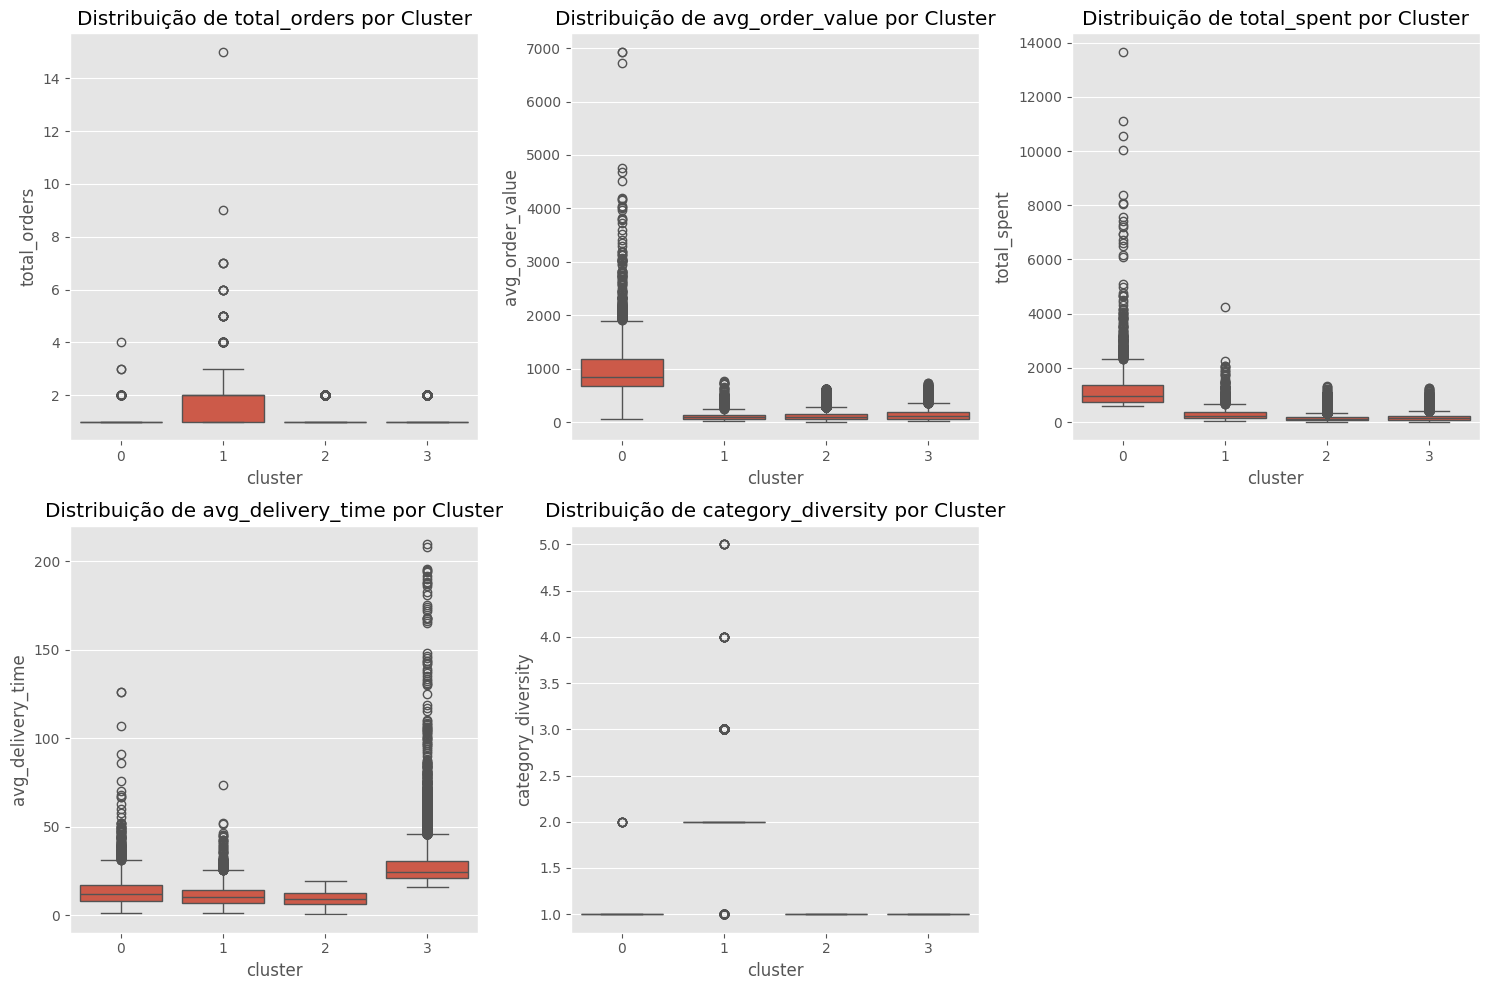

<Figure size 1400x800 with 0 Axes>

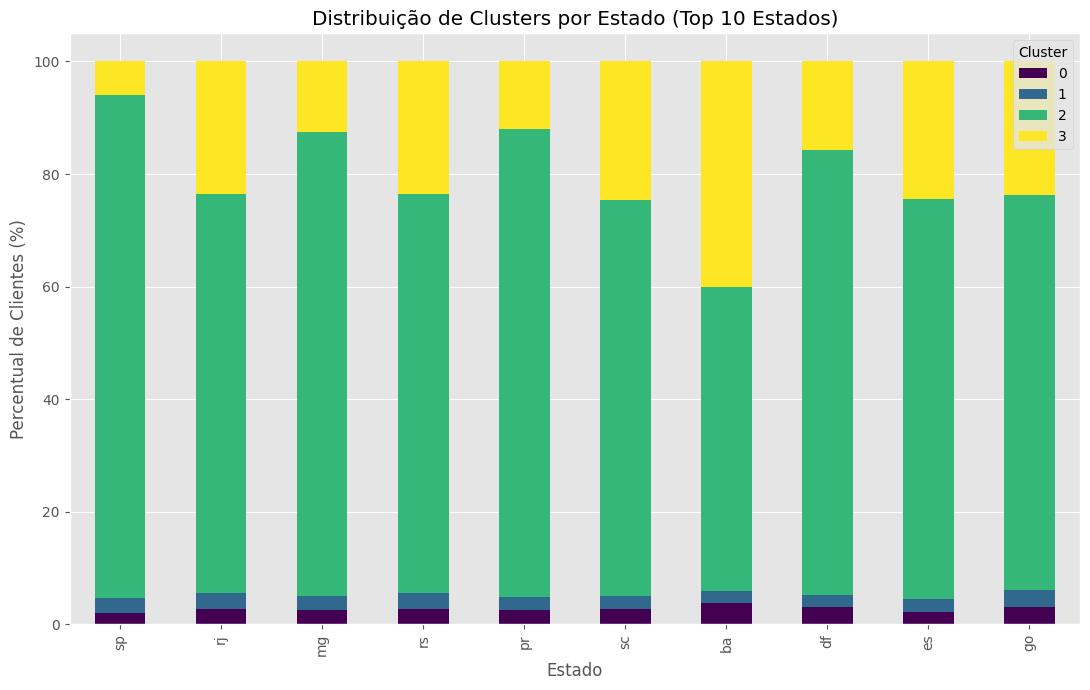

In [6]:
query = """
SELECT 
    c.customer_id,
    c.customer_state,
    COUNT(DISTINCT fs.order_id) as total_orders,
    AVG(fs.price + fs.freight_value) as avg_order_value,
    SUM(fs.price + fs.freight_value) as total_spent,
    AVG(JULIANDAY(fs.order_delivered_customer_date) - JULIANDAY(fs.order_purchase_timestamp)) as avg_delivery_time,
    COUNT(DISTINCT p.product_category_name) as category_diversity
FROM DIM_CUSTOMERS c
JOIN FACT_SALES fs ON c.customer_id = fs.customer_id
JOIN DIM_PRODUCTS p ON fs.product_id = p.product_id
WHERE fs.order_delivered_customer_date IS NOT NULL
GROUP BY c.customer_unique_id, c.customer_state
"""

segmentation_data = pd.read_sql_query(query, conn)

def segment_customers(data):
    features = ['total_orders', 'avg_order_value', 'total_spent', 'avg_delivery_time', 'category_diversity']
    
    X = data[features].copy()
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.title('Método do Cotovelo para Número Ideal de Clusters')
    plt.xlabel('Número de Clusters')
    plt.ylabel('WCSS')
    plt.grid(True)
    plt.savefig(os.path.join(output_path, 'customer_segmentation_elbow.png'))
    
    kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
    data['cluster'] = kmeans.fit_predict(X_scaled)
    
    cluster_profile = data.groupby('cluster')[features].mean().reset_index()
    
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x='cluster', y=feature, data=data)
        plt.title(f'Distribuição de {feature} por Cluster')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'customer_segmentation_profiles.png'))
    
    plt.figure(figsize=(14, 8))
    cross_tab = pd.crosstab(data['customer_state'], data['cluster'])
    cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    
    top_states = data['customer_state'].value_counts().head(10).index
    cross_tab_pct_top = cross_tab_pct.loc[top_states]
    
    cross_tab_pct_top.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Distribuição de Clusters por Estado (Top 10 Estados)')
    plt.xlabel('Estado')
    plt.ylabel('Percentual de Clientes (%)')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'customer_segmentation_states.png'))
    
    cluster_names = {
        0: 'Alto Valor',
        1: 'Compradores Frequentes',
        2: 'Compradores Casuais',
        3: 'Baixo Engajamento'
    }
    
    marketing_strategies = {
        0: "Programa de fidelidade premium, ofertas exclusivas e atendimento personalizado",
        1: "Incentivos para aumentar ticket médio, cross-selling e upselling",
        2: "Comunicações regulares com ofertas de categorias já compradas",
        3: "Re-engajamento com descontos atrativos e frete grátis"
    }
    
    data['segment_name'] = data['cluster'].map(cluster_names)
    
    cluster_profile['segment_name'] = cluster_profile['cluster'].map(cluster_names)
    cluster_profile['marketing_strategy'] = cluster_profile['cluster'].map(marketing_strategies)
    
    return {
        'segmented_data': data,
        'cluster_profile': cluster_profile,
        'cluster_names': cluster_names,
        'marketing_strategies': marketing_strategies
    }

segmentation_results = segment_customers(segmentation_data)

print("\nPerfil dos Segmentos de Clientes:")
print(segmentation_results['cluster_profile'][["cluster", "segment_name", "total_orders", "avg_order_value", "total_spent"]])

print("\nEstratégias de Marketing por Segmento:")
for cluster, name in segmentation_results['cluster_names'].items():
    print(f"Segmento {cluster}: {name}")
    print(f"Estratégia: {segmentation_results['marketing_strategies'][cluster]}\n")

## 4. Análise de Satisfação



Principais fatores que afetam a satisfação do cliente:
1. Tempo de entrega vs expectativa: -0.2281
2. Tempo total de entrega: -0.3027
3. Valor do frete: -0.0325
4. Preço do produto: 0.0036

Análise de problemas de negócio concluída com sucesso!


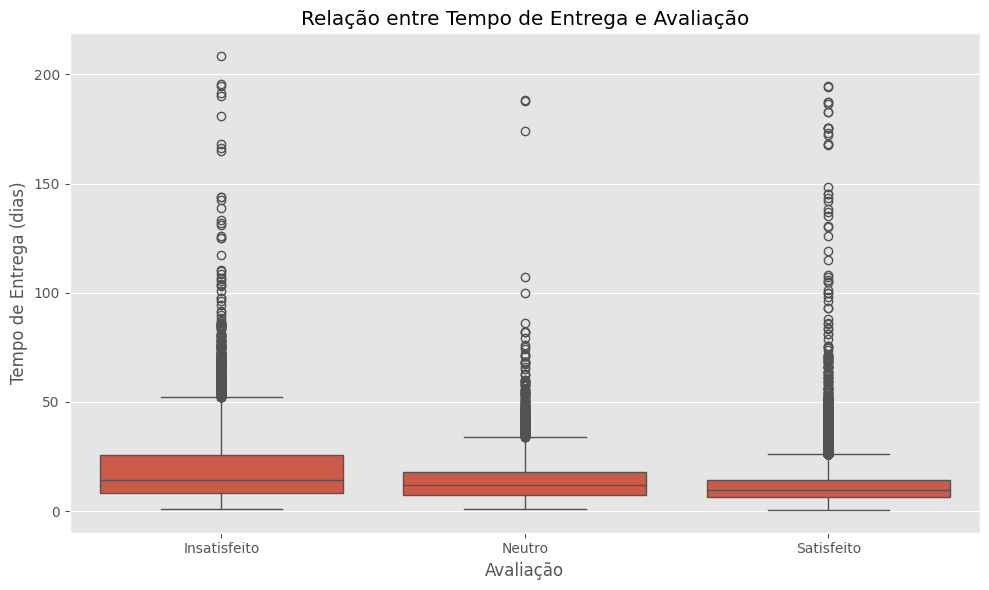

<Figure size 1000x600 with 0 Axes>

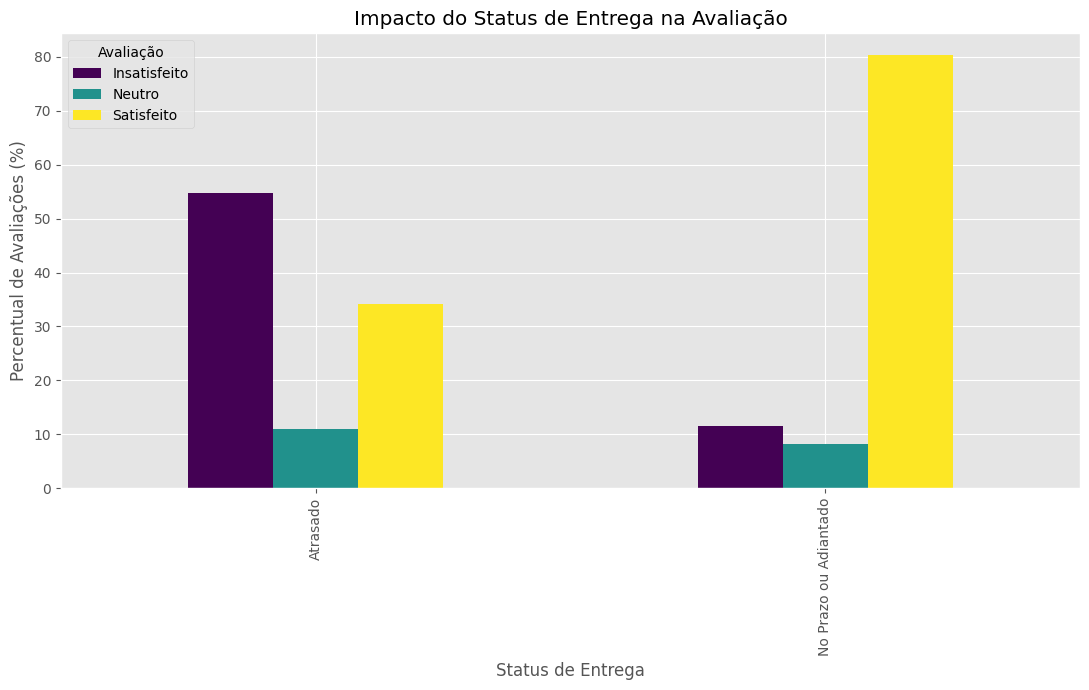

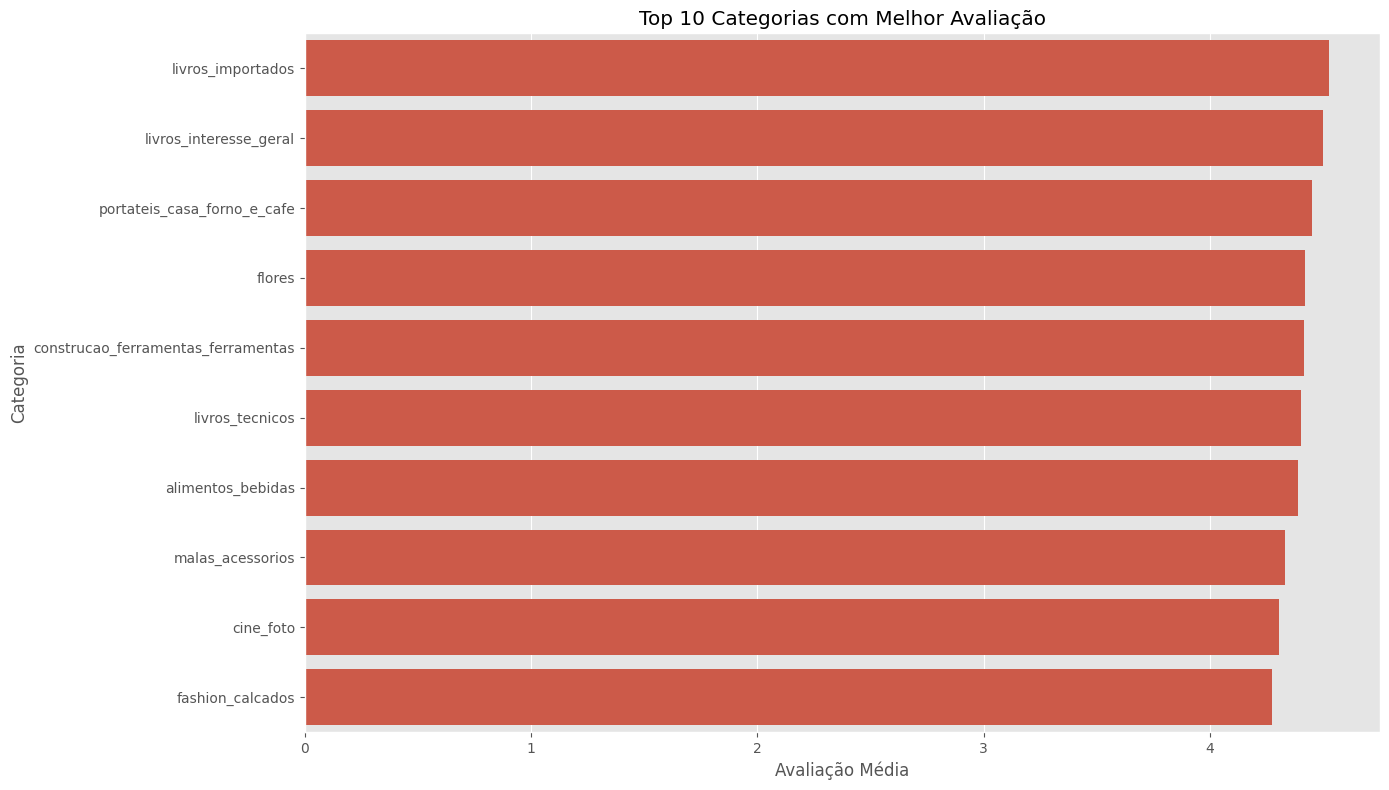

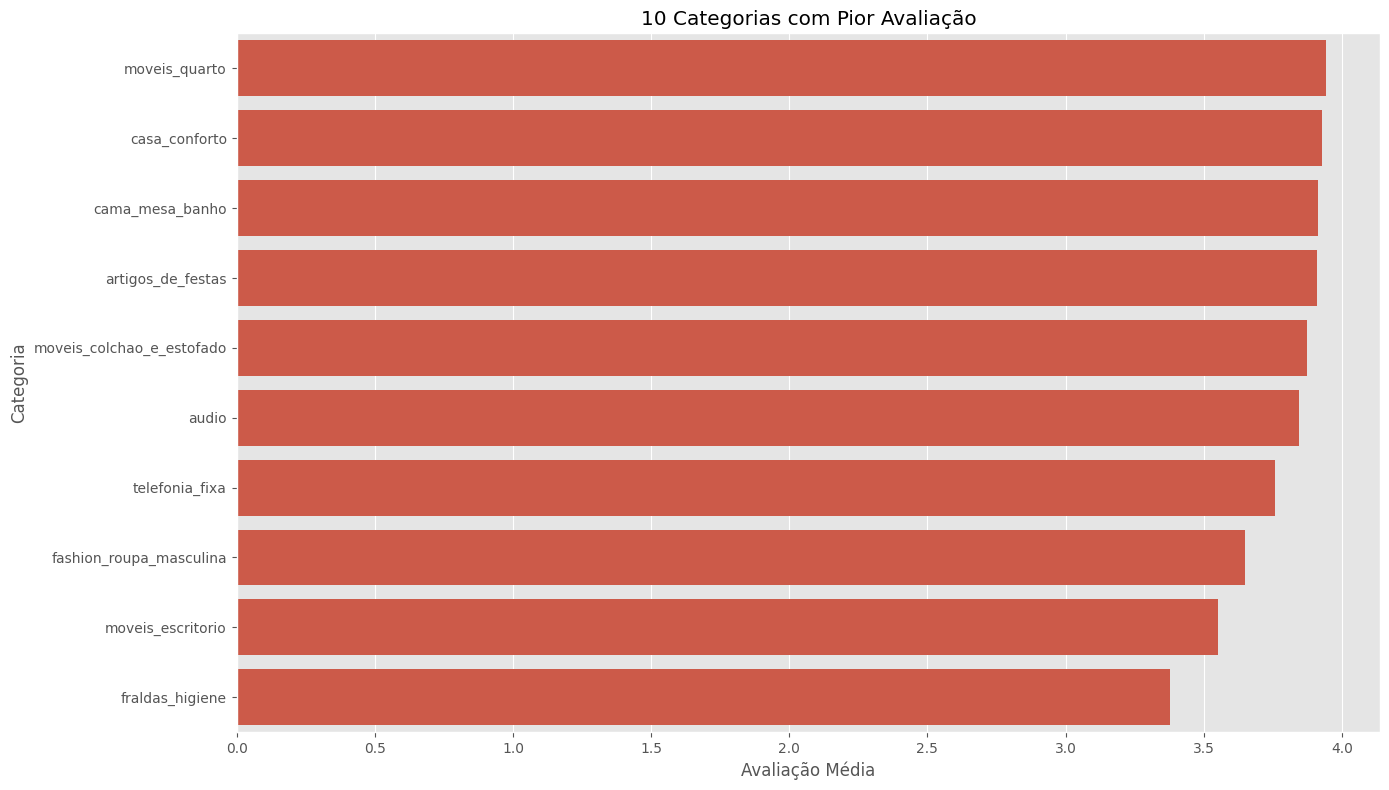

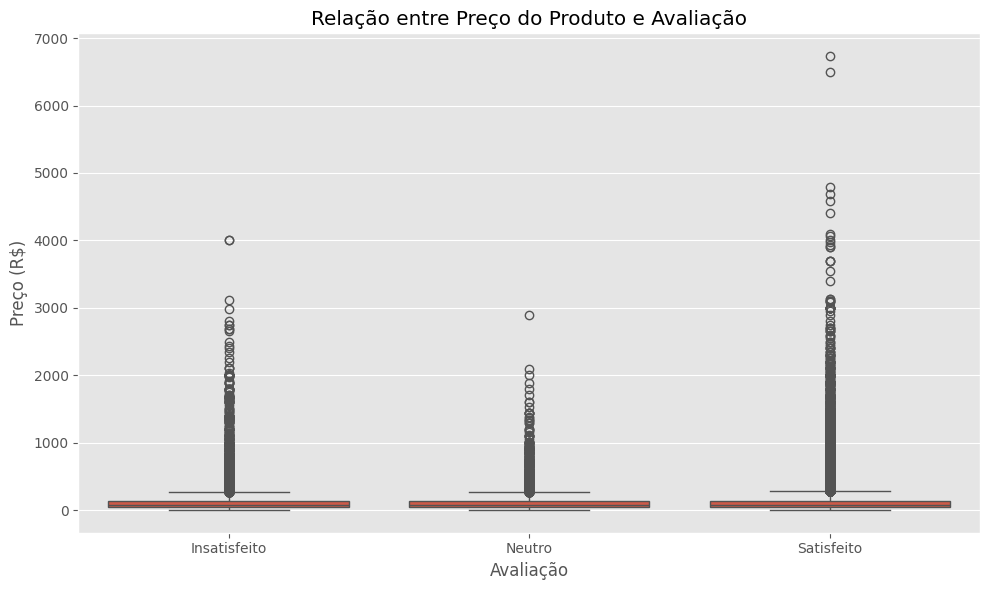

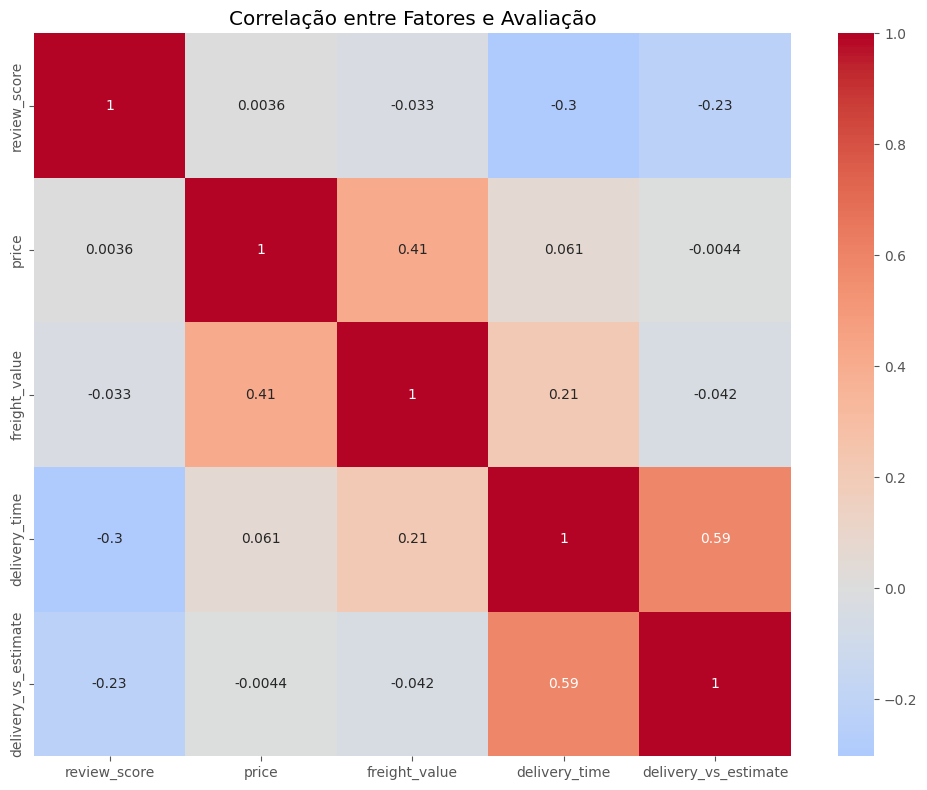

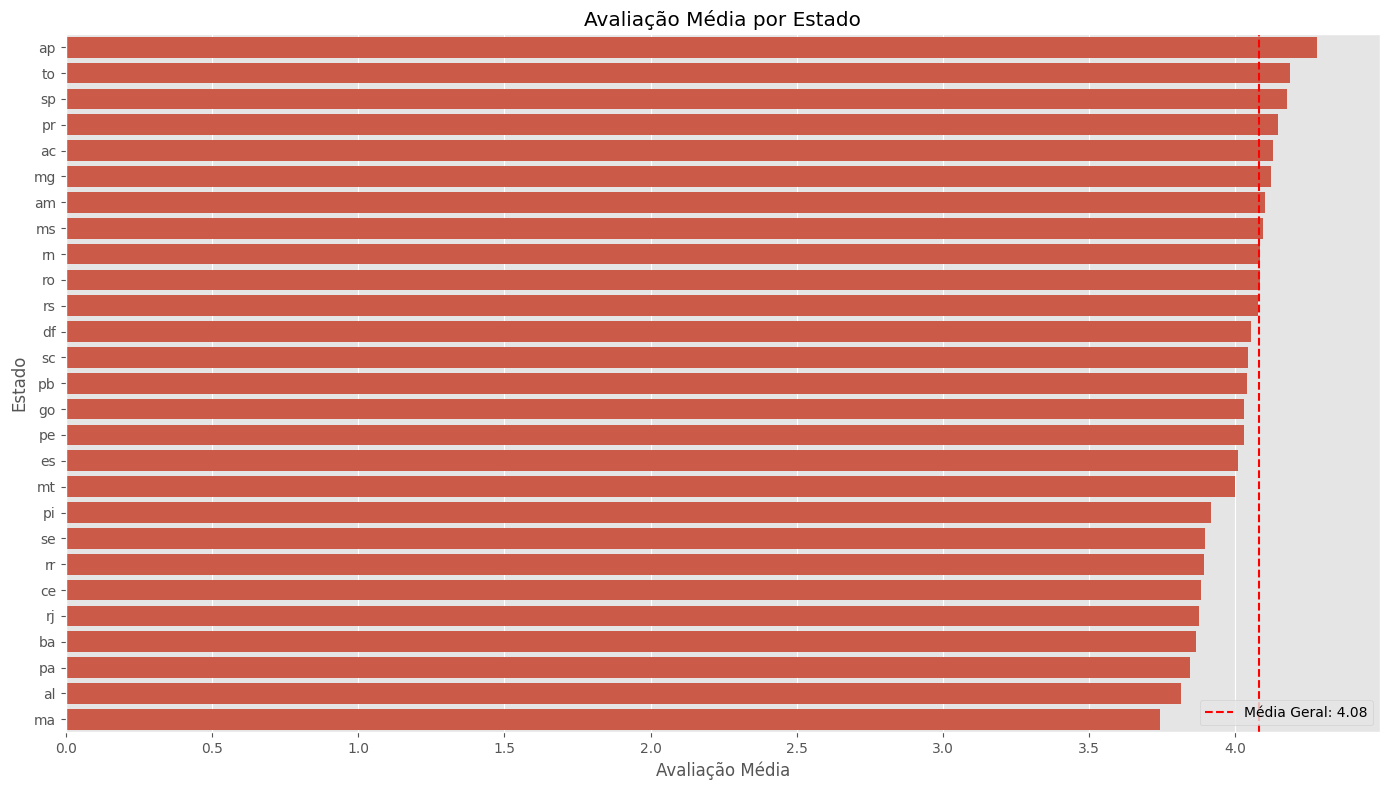

In [7]:
query = """
SELECT 
    fr.review_id,
    fr.order_id,
    fr.review_score,
    fs.price,
    fs.freight_value,
    JULIANDAY(fs.order_delivered_customer_date) - JULIANDAY(fs.order_purchase_timestamp) AS delivery_time,
    JULIANDAY(fs.order_delivered_customer_date) - JULIANDAY(fs.order_estimated_delivery_date) AS delivery_vs_estimate,
    p.product_category_name as category_name,
    c.customer_state,
    s.seller_state
FROM FACT_REVIEWS fr
JOIN FACT_SALES fs ON fr.order_id = fs.order_id
JOIN DIM_PRODUCTS p ON fs.product_id = p.product_id
JOIN DIM_CUSTOMERS c ON fs.customer_id = c.customer_id
JOIN DIM_SELLERS s ON fs.seller_id = s.seller_id
WHERE fs.order_delivered_customer_date IS NOT NULL
"""

satisfaction_data = pd.read_sql_query(query, conn)

def analyze_satisfaction(data):
    data['rating_category'] = pd.cut(
        data['review_score'], 
        bins=[0, 2, 3, 5], 
        labels=['Insatisfeito', 'Neutro', 'Satisfeito']
    )
    
    data['delivery_status'] = np.where(
        data['delivery_vs_estimate'] > 0, 
        'Atrasado', 
        'No Prazo ou Adiantado'
    )
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='rating_category', y='delivery_time', data=data)
    plt.title('Relação entre Tempo de Entrega e Avaliação')
    plt.xlabel('Avaliação')
    plt.ylabel('Tempo de Entrega (dias)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'satisfaction_delivery_time.png'))
    
    plt.figure(figsize=(10, 6))
    cross_tab = pd.crosstab(data['delivery_status'], data['rating_category'], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=False, colormap='viridis')
    plt.title('Impacto do Status de Entrega na Avaliação')
    plt.xlabel('Status de Entrega')
    plt.ylabel('Percentual de Avaliações (%)')
    plt.legend(title='Avaliação')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'satisfaction_delivery_status.png'))
    
    category_ratings = data.groupby('category_name')['review_score'].agg(['mean', 'count']).reset_index()
    category_ratings = category_ratings[category_ratings['count'] > 30].sort_values('mean', ascending=False)
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='mean', y='category_name', data=category_ratings.head(10))
    plt.title('Top 10 Categorias com Melhor Avaliação')
    plt.xlabel('Avaliação Média')
    plt.ylabel('Categoria')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'satisfaction_top_categories.png'))
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='mean', y='category_name', data=category_ratings.tail(10))
    plt.title('10 Categorias com Pior Avaliação')
    plt.xlabel('Avaliação Média')
    plt.ylabel('Categoria')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'satisfaction_bottom_categories.png'))
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='rating_category', y='price', data=data)
    plt.title('Relação entre Preço do Produto e Avaliação')
    plt.xlabel('Avaliação')
    plt.ylabel('Preço (R$)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'satisfaction_price.png'))
    
    correlation_matrix = data[['review_score', 'price', 'freight_value', 'delivery_time', 'delivery_vs_estimate']].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlação entre Fatores e Avaliação')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'satisfaction_correlation.png'))
    
    print("\nPrincipais fatores que afetam a satisfação do cliente:")
    print(f"1. Tempo de entrega vs expectativa: {correlation_matrix.loc['review_score', 'delivery_vs_estimate']:.4f}")
    print(f"2. Tempo total de entrega: {correlation_matrix.loc['review_score', 'delivery_time']:.4f}")
    print(f"3. Valor do frete: {correlation_matrix.loc['review_score', 'freight_value']:.4f}")
    print(f"4. Preço do produto: {correlation_matrix.loc['review_score', 'price']:.4f}")
    
    state_ratings = data.groupby('customer_state')['review_score'].mean().sort_values(ascending=False).reset_index()
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='review_score', y='customer_state', data=state_ratings)
    plt.title('Avaliação Média por Estado')
    plt.xlabel('Avaliação Média')
    plt.ylabel('Estado')
    plt.axvline(x=data['review_score'].mean(), color='red', linestyle='--', label=f'Média Geral: {data["review_score"].mean():.2f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'satisfaction_by_state.png'))
    
    return {
        'avg_rating': data['review_score'].mean(),
        'rating_distribution': data['review_score'].value_counts().sort_index(),
        'category_ratings': category_ratings,
        'correlation_matrix': correlation_matrix,
        'state_ratings': state_ratings
    }

satisfaction_results = analyze_satisfaction(satisfaction_data)

conn.close()

print("\nAnálise de problemas de negócio concluída com sucesso!")